Na czym się skupiamy?
Przewidywaniu czy pada deszcz kolejnego dnia.

Punkty do zrobienia:
1. Tabela NaN, statystyki NaN, odrzucenie kolumn NaN, mapa NaN
2. Sprawdzić lokalizacje, zrobić grupowanie na dane obszary, może zrzutować na mapę.
3. Różne wykresy zależności, boxploty przy ciągłych, (np. jak deszcz był kolejnego dnia to wilgotność taka a jak ni ebyło to obok drugi wykres).
4. Mapa porównań.
6. Heatmapa korelacji.
7. Przy każdym kierunku wiatru proporje tych dni w których kolejnego padało do tych gdy nie padało
8. Współczynniki korelacji między tymi samymi danymi o różnych godzinach. Jak będzie duża korelacja to uśredniami albo wybieramy jedną.
9. Może coś o powiązaniu ze zjawiskiem ENSO?
10. Może rozbić wiatr na kierunki w 4 kolumnach.
11. Wyciągnąć miesiąc z daty i to dać jako nowy parametr, zamiast daty
12. Dodać kolumnę z parametrem zjawiska ENSO z zewnętrznej ramki.

Pytania do:
1. Czy jak mamy braki danych ponad 40% to możęmy zastąpić je średnimi?

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # Plot with missing data

In [56]:
df = pd.read_csv('weatherAUS.csv')

## Data Analysis

In [57]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [58]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [59]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [60]:
# Numerical and categorical values
categorical= df.select_dtypes(include=['object']).columns
print("Categorical: ", list(categorical))

numerical = df.select_dtypes(include=['number']).columns
print("Numerical: ", list(numerical))

Categorical:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
Numerical:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Evaporation'}>],
       [<Axes: title={'center': 'Sunshine'}>,
        <Axes: title={'center': 'WindGustSpeed'}>,
        <Axes: title={'center': 'WindSpeed9am'}>,
        <Axes: title={'center': 'WindSpeed3pm'}>],
       [<Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>,
        <Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>],
       [<Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>,
        <Axes: title={'center': 'Temp9am'}>,
        <Axes: title={'center': 'Temp3pm'}>]], dtype=object)

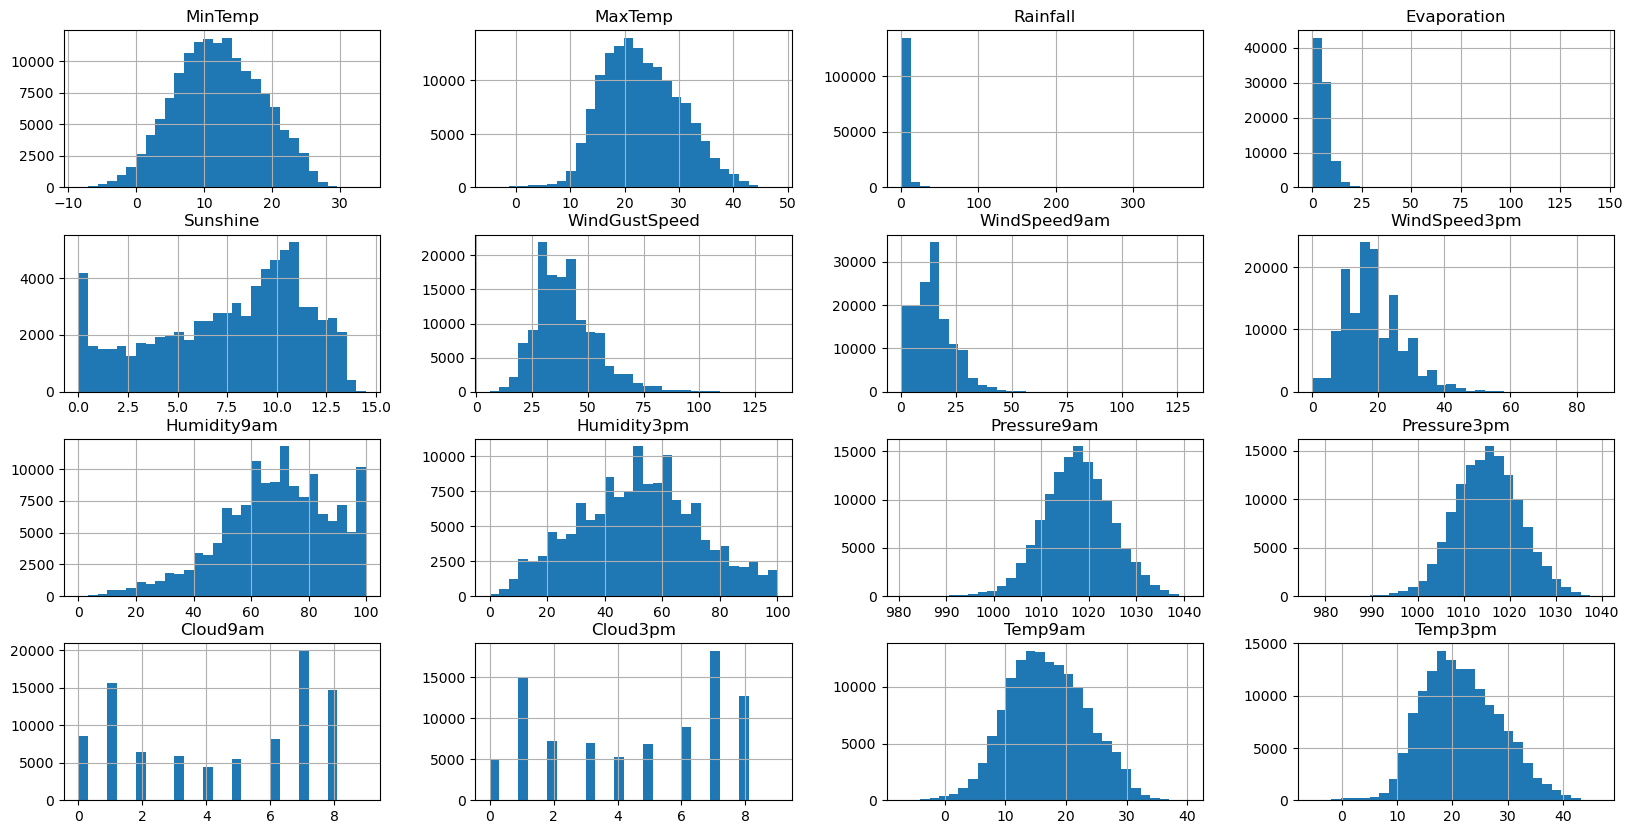

In [61]:
# 
df.hist(figsize=(20, 10), bins=30)  


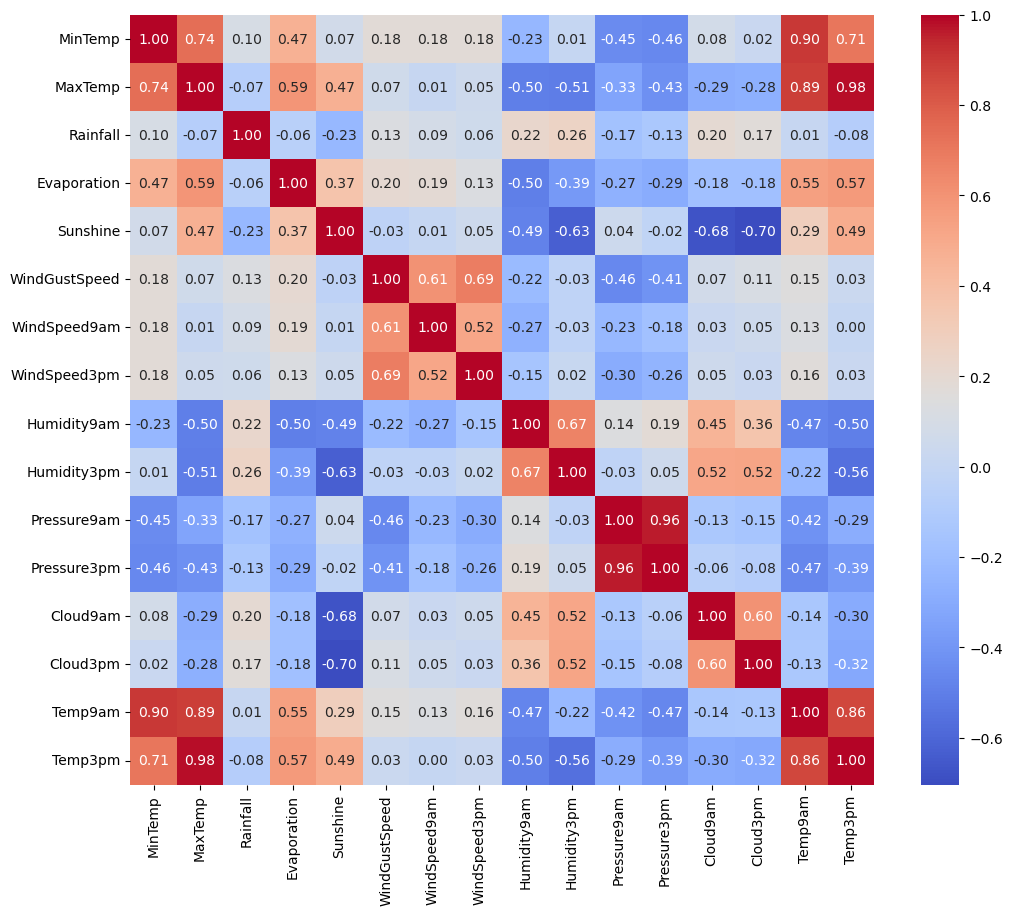

In [62]:
# We want to identify the correlation with missing values and then again without them.
nan_numerical_df = df.select_dtypes(include=['number'])
nan_correlation_matrix = nan_numerical_df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(nan_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

## Missing Values

In [63]:
# Adding new column with a month (Tutaj czy nie tutaj? jak uzyjemy to mozna juz tutaj, a jak nie to EDA chyba)
#Zostawiłbym tutaj, przyda się do dodania wartości
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month

print(df)

             Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1      2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2      2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3      2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4      2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
...           ...      ...      ...      ...       ...          ...       ...   
145455 2017-06-21    Uluru      2.8     23.4       0.0          NaN       NaN   
145456 2017-06-22    Uluru      3.6     25.3       0.0          NaN       NaN   
145457 2017-06-23    Uluru      5.4     26.9       0.0          NaN       NaN   
145458 2017-06-24    Uluru      7.8     27.0       0.0          NaN       NaN   
145459 2017-06-25    Uluru     14.9      NaN       0.0          NaN       NaN   

       WindGustDir  WindGus

In [64]:
# Handling missing values - RainTomorrow an RainToday. Those are binary values and it is hard to replace them with other values.
df.dropna(axis=0, subset=['RainToday','RainTomorrow'], inplace=True) 

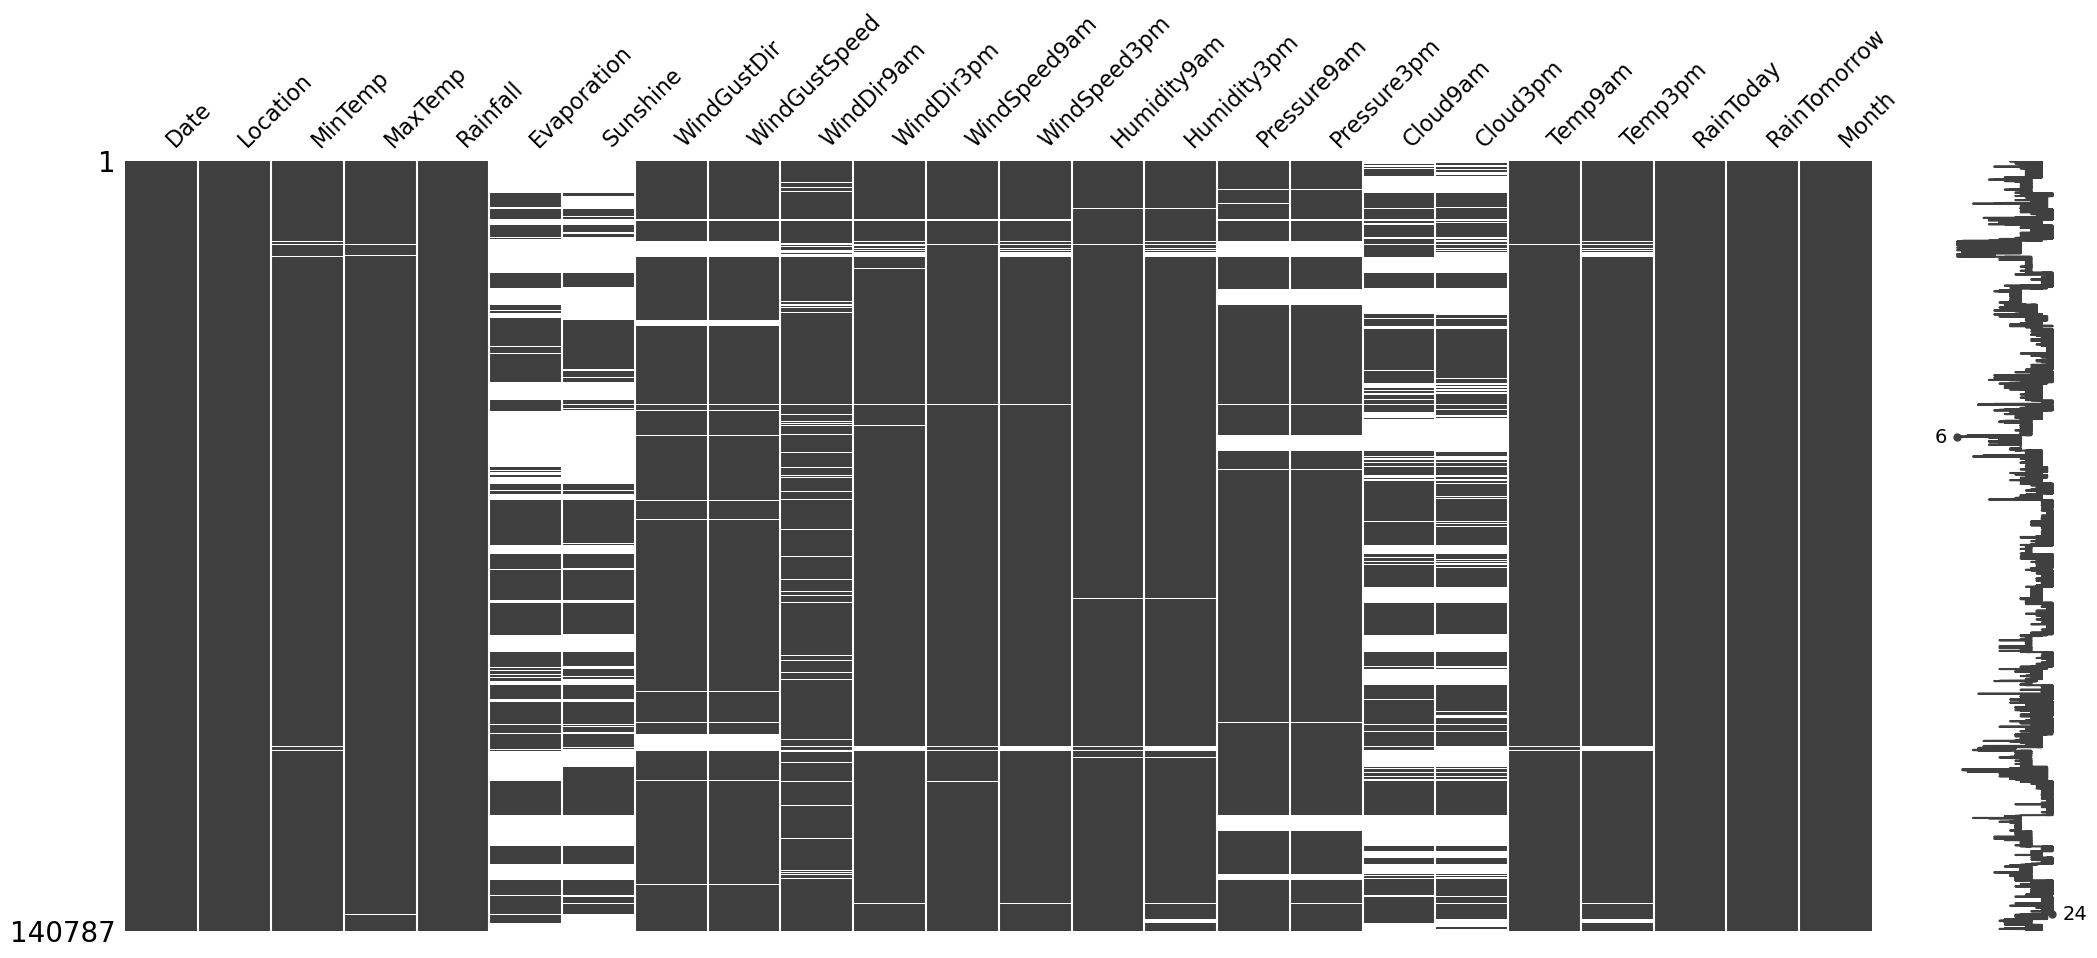

In [65]:
# Plot shows missing values
msno.matrix(df)
plt.show()

In [66]:
#Function for making stats about missing values
def missing(dataframe):
    total = dataframe.isnull().sum()
    percent = round(dataframe.isnull().sum()/len(df)*100, 2)
    missing = pd.concat([percent,total], axis=1, keys=['Percent','Total']).sort_values(by = ['Percent'], ascending = False).T
    return missing

In [67]:
missing(df)

,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,WindDir9am,WindGustDir,WindGustSpeed,WindDir3pm,...,WindSpeed9am,Temp9am,MinTemp,MaxTemp,RainToday,RainTomorrow,Date,Location,Rainfall,Month
Percent,47.45,42.4,39.84,37.38,9.78,9.76,6.86,6.51,6.47,2.61,...,0.75,0.47,0.33,0.22,0.0,0.0,0.0,0.0,0.0,0.0
Total,66805.00,59694.0,56094.00,52625.00,13769.00,13743.00,9660.00,9163.00,9105.00,3670.00,...,1055.00,656.00,468.00,307.00,0.0,0.0,0.0,0.0,0.0,0.0


### Handling missing categorical values

In [68]:
df_with_missing = df.copy()

In [69]:
# Handling categorical missing values ('WindGustDir', 'WindDir9am', 'WindDir3pm'). We want to replace them in each location with mode.
modes = df[categorical[2:5]].apply(pd.Series.mode).to_dict("list")
modes = {i:modes[i][0] for i in modes}

df_cat = df[categorical].dropna()
loc_cat = df_cat.groupby(['Location'])[categorical[2:5]].agg(pd.Series.mode)
del df_cat
print(loc_cat.shape[0], df.Location.nunique())
loc_cat.T
# We can see two Locations missing, taht means they contain only NaN values in at least one column.

47 49


Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,...,ENE,NW,E,ENE,SE,N,WNW,SSE,NE,SSE
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,...,SE,NW,E,E,NW,ENE,WNW,SE,SW,SE
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,...,ENE,NW,E,WSW,SSE,SSW,SE,SSE,NE,SSW


In [70]:
missing_locations = list(set(df.Location.unique().tolist()) - set(loc_cat.index.tolist()))
print(missing_locations)
# We will replace NaN in those locations with mode values for whole data frame (counted higher), where there is a need.

['Newcastle', 'Albany']


In [71]:
for loc in missing_locations:
    x = df[df['Location'] == loc][categorical[2:5]].apply(pd.Series.mode)
    x.fillna(modes, inplace = True)
    x.index = [loc]
    loc_cat = pd.concat([loc_cat, x], axis = 0)
loc_cat.T

,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,Newcastle,Albany
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,...,E,ENE,SE,N,WNW,SSE,NE,SSE,W,W
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,...,E,E,NW,ENE,WNW,SE,SW,SE,NW,NW
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,...,E,WSW,SSE,SSW,SE,SSE,NE,SSW,SE,ESE


In [72]:
# Now we have proper dimensions
loc_cat.shape

(49, 3)

In [73]:
for l in df.Location.unique():  
    if l not in loc_cat.index:
        continue  

    indices = df[df['Location'] == l].index
    for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        value = loc_cat.loc[l, col]
        
        if isinstance(value, (np.ndarray, list)) and len(value) > 0:
            value = value[0]  
        
        if not isinstance(value, (str, int, float)):
            value = np.nan  
        
        df.loc[indices, col] = df.loc[indices, col].fillna(value)
        loc_cat.loc[l, col] = value  

### Handling missing numerical values

In [74]:
# There are many missing numerical values 
df.isnull().sum().sum()

284494

In [75]:
# Średnia wartość dla każdej kombinacji (Location, Month)
loc_month_num = df.groupby(['Location', 'Month'])[df.columns[df.isnull().any()]].mean()

# Średnia dla danego miesiąca (niezależnie od lokalizacji)
month_num = df.groupby('Month')[df.columns[df.isnull().any()]].mean()


In [76]:
for l in df.Location.unique():
    for m in df.Month.unique():
        indices = df[(df['Location'] == l) & (df['Month'] == m)].index
        available_nan = df.columns[df.isnull().any()]  

        for col in available_nan:
            try:
                # Pobieramy średnią dla (Location, Month)
                value = loc_month_num.loc[(l, m), col]

                # Jeśli nie ma danych dla danej lokalizacji → bierzemy średnią z innych miast dla danego miesiąca
                if pd.isna(value):
                    value = month_num.loc[m, col]  # Pobieramy średnią dla miesiąca (wszystkie miasta)

                # Jeśli wartość jest listą, pobieramy pierwszą
                if pd.api.types.is_list_like(value):
                    value = value[0] if len(value) > 0 else np.nan  

                # Wypełniamy brakujące wartości
                df.loc[indices, col] = df.loc[indices, col].fillna(value)

            except KeyError:
                continue

In [77]:
#Stare
# # We count proper means for each city
# loc_num = df.groupby(['Location'])[df.columns[df.isnull().any()]].mean()
# loc_num.fillna(df[loc_num.columns].mean(), inplace = True)

# # We replace all NaN now
# for l in df.Location.unique():  
#     indices = df[df['Location'] == l].index
#     available_nan = df.columns[df.isnull().any()]  

#     for col in available_nan:
#         value = loc_num.loc[l, col]

#         if pd.api.types.is_list_like(value):
#             value = value[0] if len(value) > 0 else np.nan  
            
#         df.loc[indices, col] = df.loc[indices, col].fillna(value)

In [78]:
# There are no NaN hurayyyyy!!!
df.isnull().sum().sum()

0

Let's check if our method is correct.

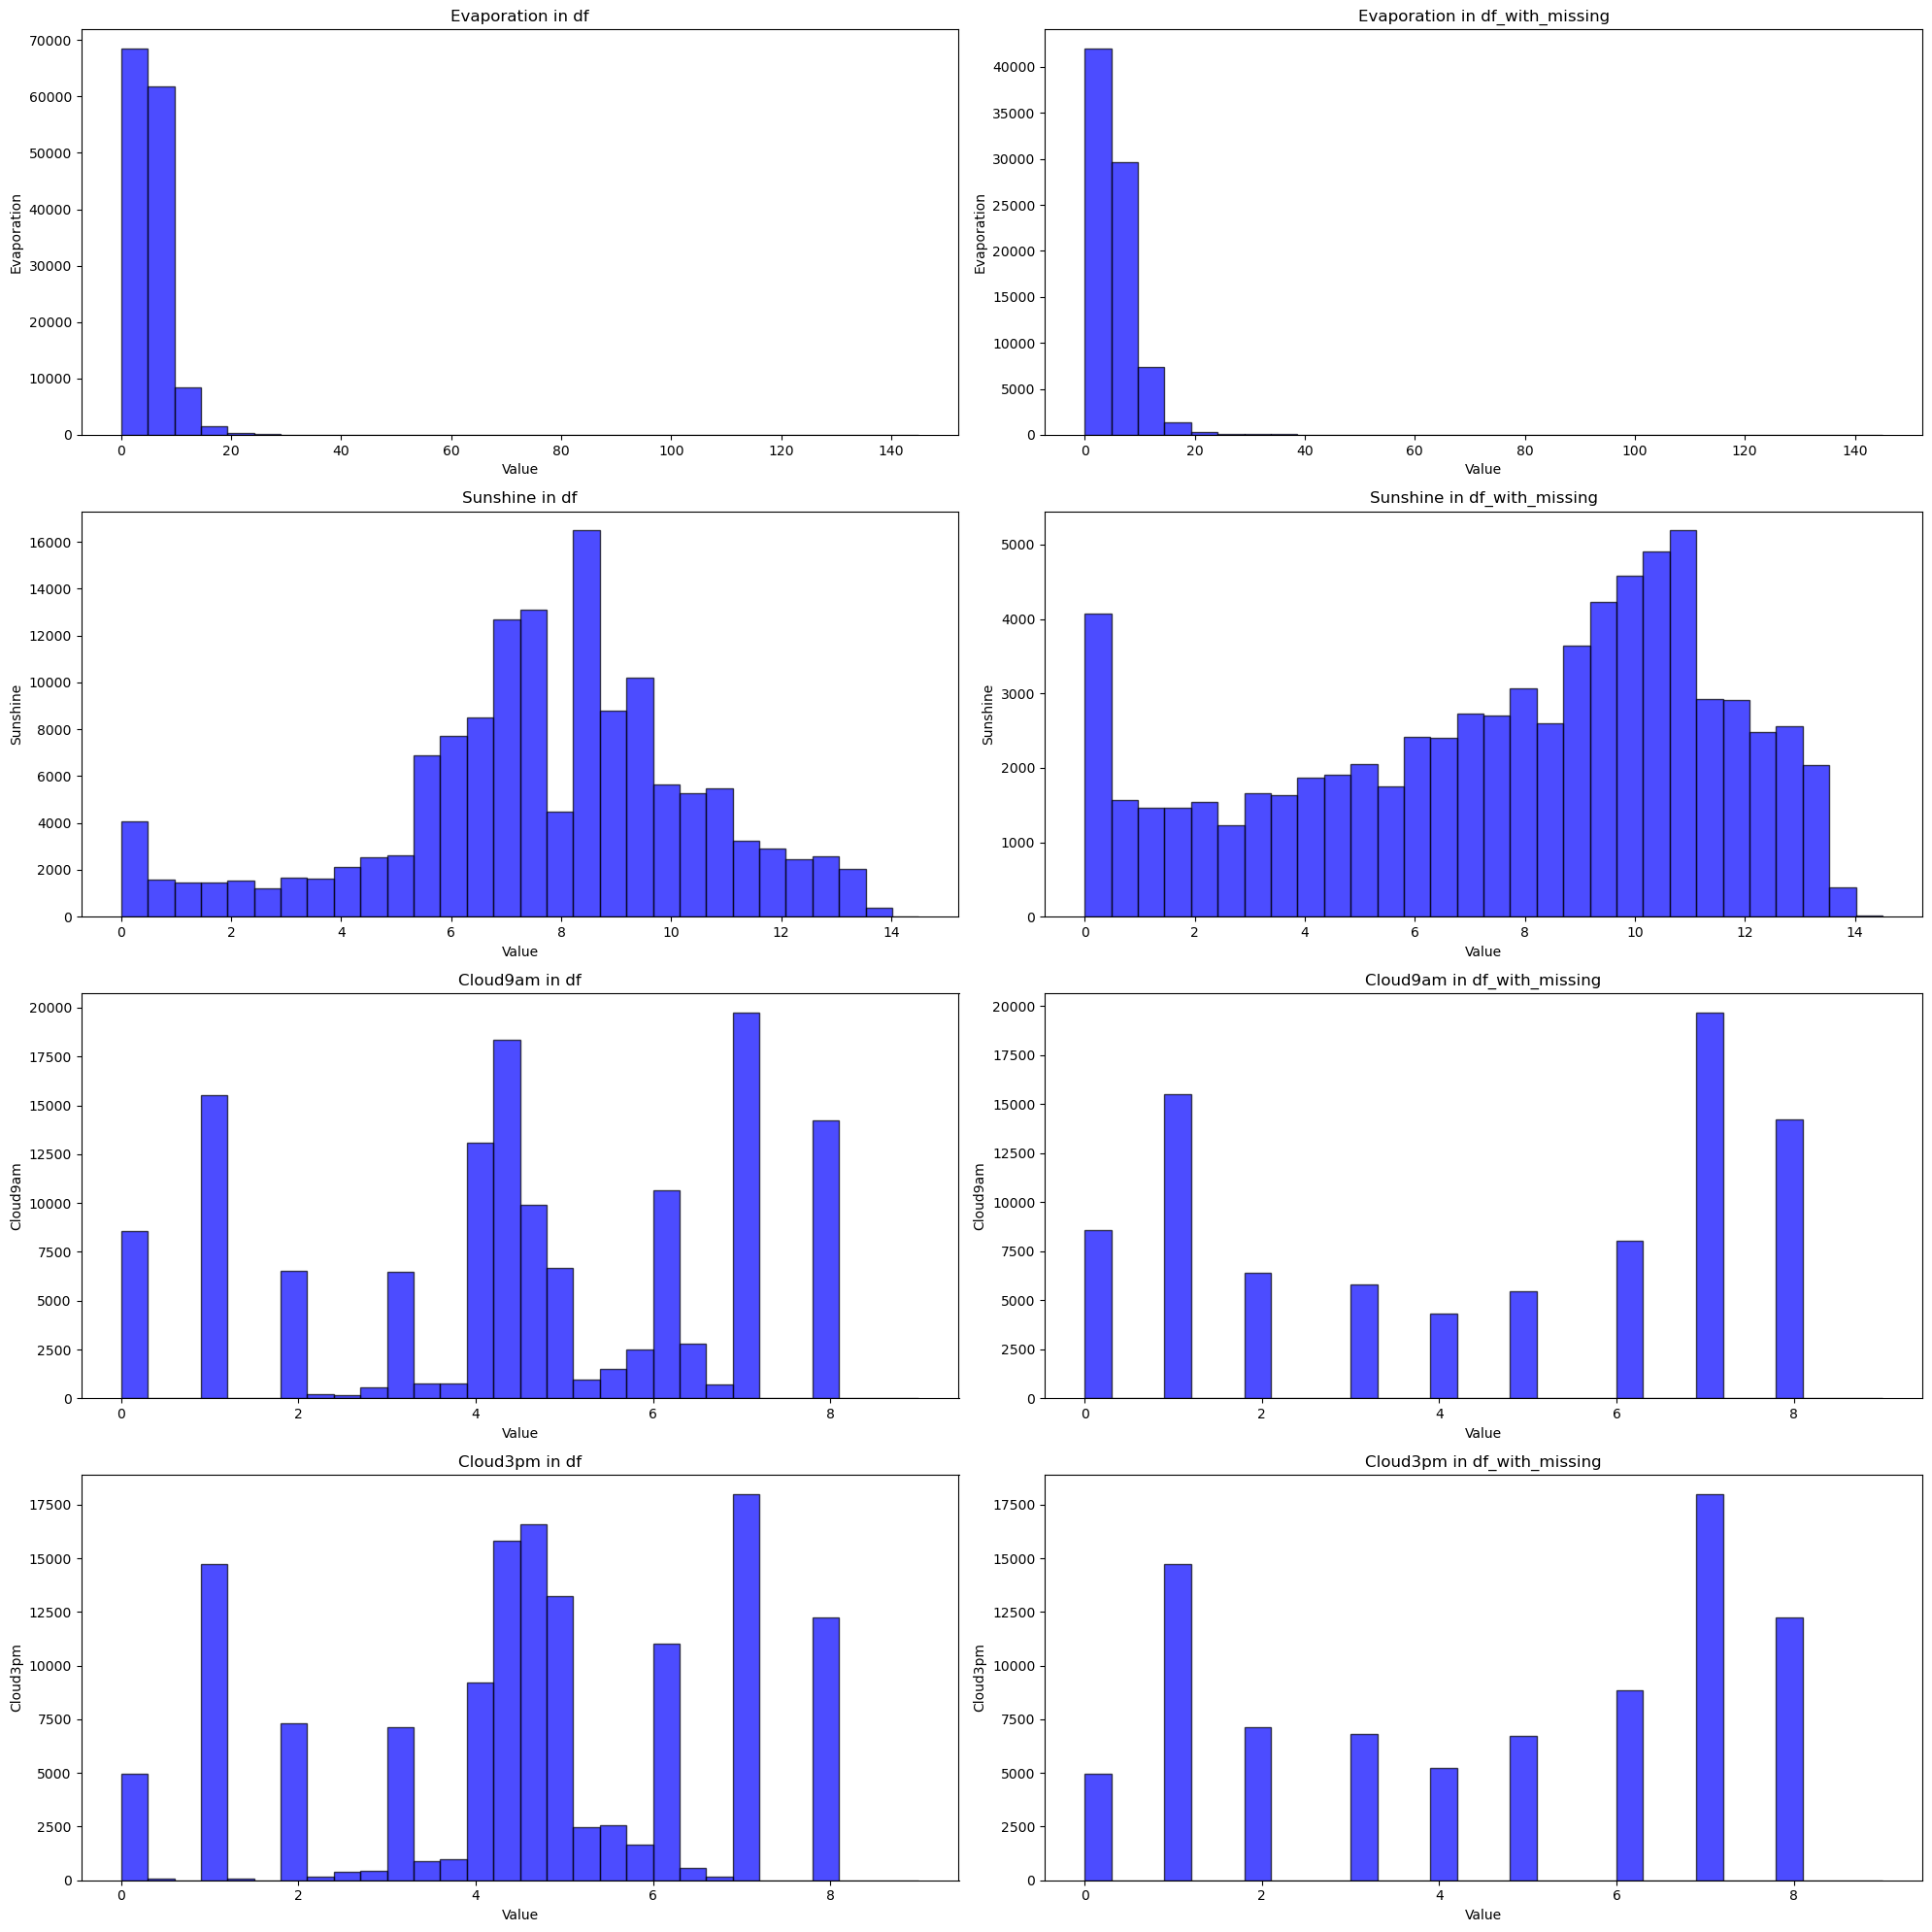

In [79]:
nan_columns = ['Evaporation','Evaporation', 'Sunshine', 'Sunshine','Cloud9am', 'Cloud9am','Cloud3pm', 'Cloud3pm']

n_rows = 4
n_cols = 2

# Zmienna, która będzie przechowywać różne DataFrame
dfs = [df, df_with_missing]
df_names = ['df', 'df_with_missing']  # Nazwy DataFrame'ów

plt.figure(figsize=(20, 20))

for i, column in enumerate(nan_columns):
    current_df = dfs[i % 2]  # Naprzemienne używanie df i df_with_missing
    current_df_name = df_names[i % 2]  # Określenie nazwy DataFrame
    plt.subplot(n_rows, n_cols, i + 1)  
    plt.hist(current_df[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{column} in {current_df_name}')
    plt.xlabel('Value')
    plt.ylabel(column)

plt.tight_layout()
plt.show() 

In [80]:
df2 = df_with_missing.copy()

df2.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12


In [113]:
df2 = df_with_missing.copy()

from sklearn.impute import KNNImputer


# Zakładam, że df_with_missing to Twój oryginalny DataFrame
df2 = df_with_missing.copy()

df2 = df2.head(30000)

# Wybieramy tylko kolumny numeryczne
numerical_cols = [col for col in df2.select_dtypes(include=['float64', 'int64']).columns 
                           if df2[col].isnull().any() and col not in ['Sunshine', 'Evaporation']]

# Tworzymy instancję KNNImputera
imputer = KNNImputer(n_neighbors=3)

# Imputujemy brakujące dane we wszystkich numerycznych kolumnach
imputed_data = imputer.fit_transform(df2[numerical_cols])

# Przekształcamy imputowane dane na DataFrame z odpowiednimi nazwami kolumn
imputed_df = pd.DataFrame(imputed_data, columns=numerical_cols)

# Zastępujemy imputowane kolumny w oryginalnym DataFrame
df2[numerical_cols] = imputed_df

# Sprawdzamy wynik
print(df2.head())

        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0 2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1 2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2 2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3 2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4 2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1  8.00000

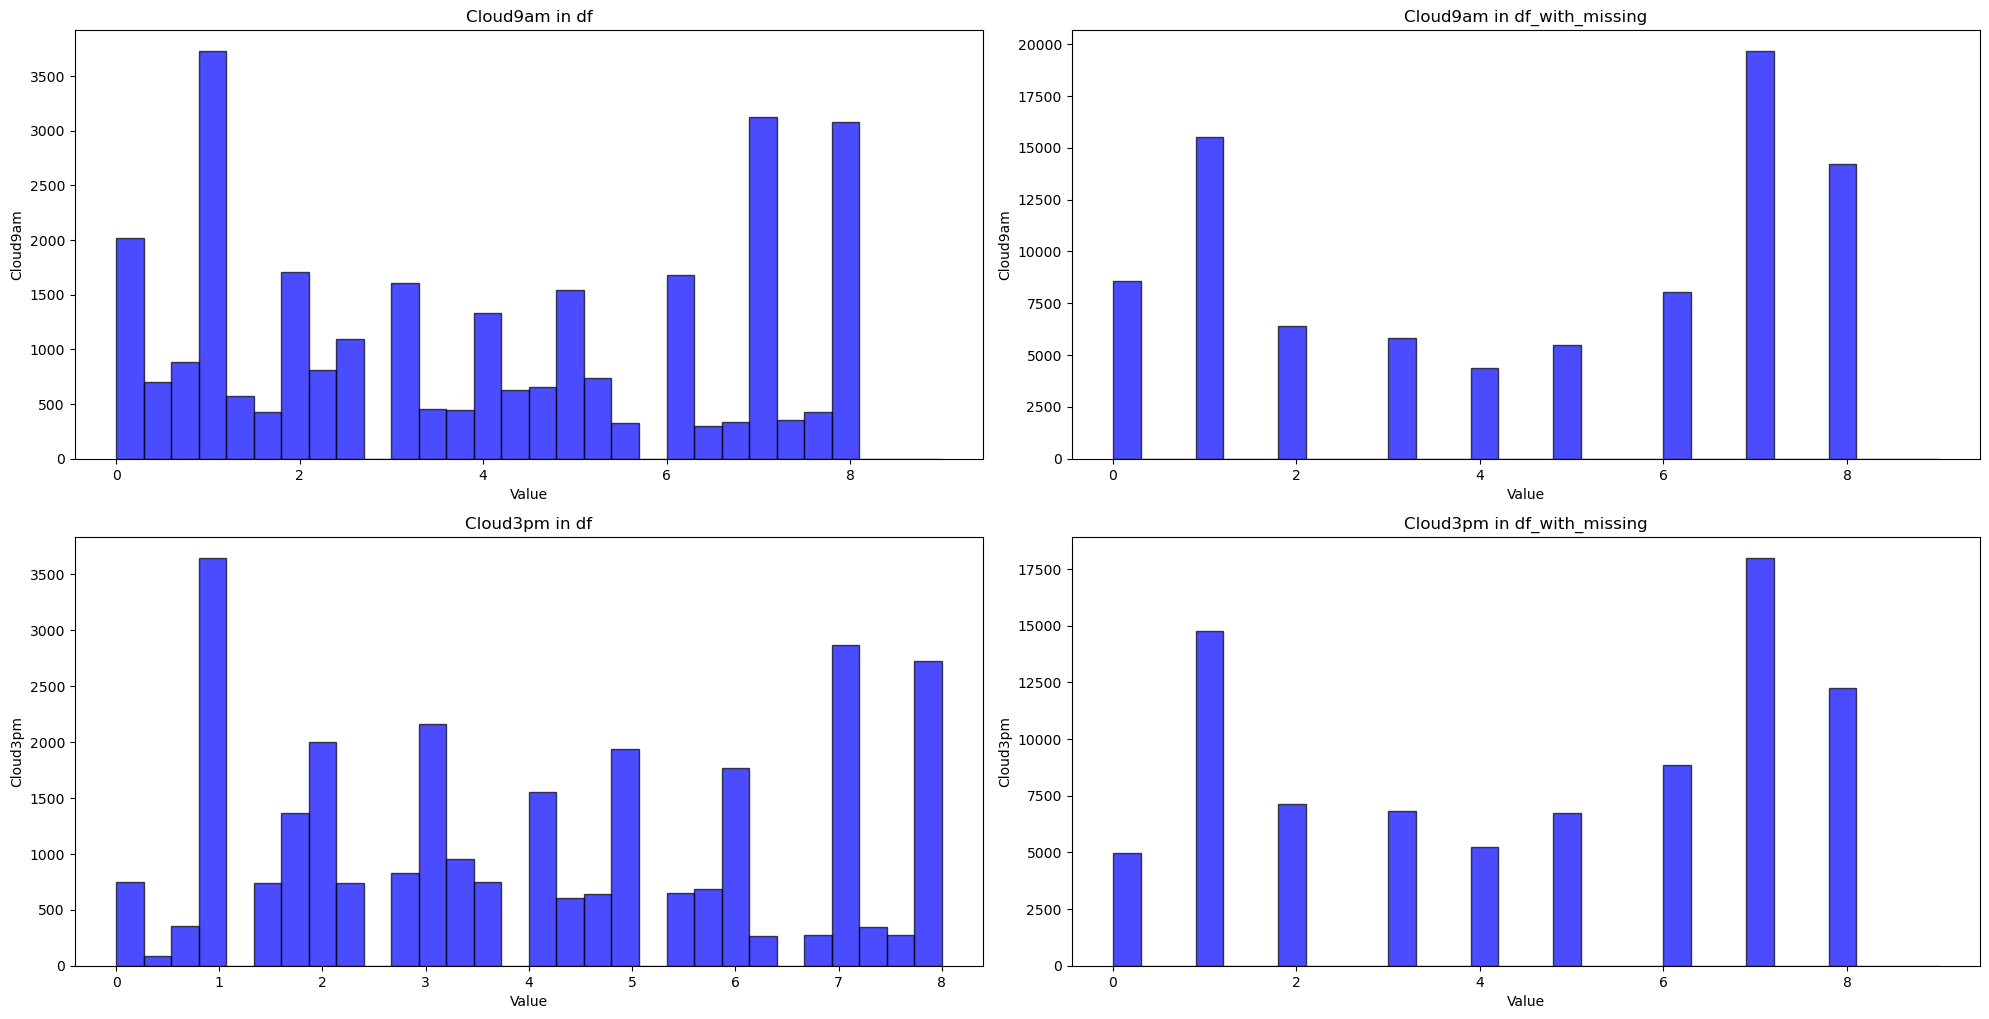

In [115]:
nan_columns = ['Cloud9am', 'Cloud9am','Cloud3pm', 'Cloud3pm']

n_rows = 4
n_cols = 2

# Zmienna, która będzie przechowywać różne DataFrame
dfs2 = [df2, df_with_missing]
df_names = ['df', 'df_with_missing']  # Nazwy DataFrame'ów

plt.figure(figsize=(20, 20))

for i, column in enumerate(nan_columns):
    current_df = dfs2[i % 2]  # Naprzemienne używanie df i df_with_missing
    current_df_name = df_names[i % 2]  # Określenie nazwy DataFrame
    plt.subplot(n_rows, n_cols, i + 1)  
    plt.hist(current_df[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{column} in {current_df_name}')
    plt.xlabel('Value')
    plt.ylabel(column)

plt.tight_layout()
plt.show() 

## EDA

#### Dependence of weather factors on rain the following day

We want to identify where the boxplots show significant differences - potentially have a stronger influence on the rain the next day. Thanks to them, we can see that the weather conditions definitely have an impact on the next day's rain.
We can see that larger differences occur in humidity, pressure, and temperature during later hours, which will be important later.

In [ ]:

numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                     'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
n_rows = 4
n_cols = 4

plt.figure(figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

The correlation between some factors is probably very high. For example temperature:

In [ ]:
sns.pairplot(data=df, vars=('MaxTemp','MinTemp','Temp9am','Temp3pm'), hue='RainTomorrow')
plt.show()

And a very similar situation with pressure:

In [ ]:
sns.pairplot(data=df, vars=('Pressure9am', 'Pressure3pm'), hue='RainTomorrow')
plt.show()

But for example the correlation is not so high for wind and humidity:

In [ ]:
sns.pairplot(data=df, vars=('WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm'), hue='RainTomorrow')
plt.show()

Now we are sure that we should combine some columns - MaxTemp with Temp3pm, MinTemp with Temp9am, Pressure together
So maybe a mean? However, from the boxplots, we saw that later hours had a greater impact, so we will take them into account.

In [ ]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()


### Outliers

From previous plots we can see that there are many outliers, we decide to logarithm some of them them in order reduce their influence

In [ ]:
df['Rainfall'] = np.log1p(df['Rainfall'])  
df['Evaporation'] = np.log1p(df['Evaporation'])
df['WindGustSpeed'] = np.log1p(df['WindGustSpeed'])
df['WindSpeed9am'] = np.log1p(df['Rainfall'])  
df['WindSpeed3pm'] = np.log1p(df['Evaporation'])


For other columns we decide to relace outliers that ar over 3σ with 3σ. 

In [ ]:
sigma_numerical = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Temp9am', 'Temp3pm']

def replace_outliers(df, num_cols, threshold=3):
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

df = replace_outliers(df, sigma_numerical)

In [ ]:
# n_rows = 4
# n_cols = 4

# plt.figure(figsize=(20, 20))
# for i, column in enumerate(numerical_columns):
#     plt.subplot(n_rows, n_cols, i+1)  
#     sns.boxplot(x='RainTomorrow', y=column, data=df)
#     plt.title(f'{column} vs RainTomorrow')
#     plt.xlabel('RainTomorrow')
#     plt.ylabel(column)

# plt.tight_layout()
# plt.show()

We would also like to check what is the correlation of each parameter to TomorrowRain. To do that we have to change te type of some columns. 

In [ ]:
df.columns

In [ ]:
# Konwersion of Rain columns to 0/1
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

num_cols = df.select_dtypes(include=['float64']).columns

# Correlation with "RainTomorrow"
correlation = df[num_cols].corrwith(df['RainTomorrow']).sort_values(ascending=False)

correlation


The deletion of these columns should help in predicting rain. Ale jaka decyzja? Łączymy wsyztskie temperatury, ktora zostawiamy?? Pressure pozniejsze, ale moze warto to sprawdzic jakas metryka jeszcze?

In [ ]:
#df = df.drop(columns=['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm'])

# Wyświetlenie wynikowego DataFrame
print(df)